In [1]:
import os
os.chdir("/mnt/iusers01/jw01/mdefscs4/ra_challenge/hestia/Hestia_imeche_vision_challenge/NN_recognition_train")

In [2]:
import dataset.square_generation
import matplotlib.pyplot as plt
import numpy as np

In [3]:
out_array, coords, letter, color = dataset.square_generation.stitch_random_square("/mnt/iusers01/jw01/mdefscs4/ra_challenge/hestia/Hestia_imeche_vision_challenge/data/true_negatives_pretrain/frame_grass_2_1064.jpeg")


In [8]:
def align_coords(coords):
    X = np.array((coords["A_X"], coords["B_X"], coords["C_X"], coords["D_X"]))
    Y = np.array((coords["A_Y"], coords["B_Y"], coords["C_Y"], coords["D_Y"]))
    average_X = np.mean(X)
    average_Y = np.mean(Y)
    total_h = np.max(Y) - np.min(Y)
    total_w = np.max(X) - np.min(X)
    
    return np.array((average_X/1000, average_Y/1000, total_h/1000, total_w/1000))

In [9]:
align_coords(coords)

array([0.83777502, 0.24771499, 0.06623425, 0.05998892])

In [31]:
sums = np.array((coords["A_X"] + coords["A_Y"], coords["B_X"] + coords["B_Y"], coords["C_X"] + coords["C_Y"], coords["D_X"] + coords["D_Y"]))

In [32]:
top_left = np.argmin(sums)
bottom_right = np.argmax(sums)

In [42]:
a = list(idx_Y)
a.remove(top_left)
a.remove(bottom_right)

In [43]:
top_right = a[0]
bottom_left

[2, 1]

In [12]:
X = np.array((coords["A_X"], coords["B_X"], coords["C_X"], coords["D_X"]))
Y = np.array((coords["A_Y"], coords["B_Y"], coords["C_Y"], coords["D_Y"]))

In [25]:
idx_X = np.argsort(X)
idx_Y = np.argsort(Y)

In [27]:
idx_X

array([1, 0, 3, 2])

In [28]:
idx_Y

array([0, 2, 1, 3])

In [9]:
coords

{'X': 528.8588983348353,
 'Y': 528.8675452053653,
 'A_X': 514.8865379807693,
 'B_X': 471.8828026692582,
 'C_X': 586.3236728107705,
 'D_X': 542.3425798785432,
 'A_Y': 468.8902732922804,
 'B_Y': 545.6670845653301,
 'C_Y': 511.19554208093405,
 'D_Y': 589.7172808829167}

In [67]:
import os
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import tensorflow.keras as k
import glob
from dataset.square_generation import stitch_random_square
from PIL import Image

DATASET_DIR = "../data/grass_pretrain"
TRUE_NEGATIVES_DIR = "../data/true_negatives_pretrain"


STITCH_PROB = 0.5
TRUE_NEG_PRO = 0.2

alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


list_of_grass_images = glob.glob(DATASET_DIR + "/*jpeg")
list_of_negative_images = glob.glob(TRUE_NEGATIVES_DIR + "/*jpeg")

def align_coords(coords):
    sums = np.array((coords["A_X"] + coords["A_Y"], coords["B_X"] + coords["B_Y"], coords["C_X"] + coords["C_Y"], coords["D_X"] + coords["D_Y"]))
    X = np.array((coords["A_X"], coords["B_X"], coords["C_X"], coords["D_X"]))
    Y = np.array((coords["A_Y"], coords["B_Y"], coords["C_Y"], coords["D_Y"]))
    idx_Y = np.argsort(Y)
    top_left = np.argmin(sums)
    bottom_right = np.argmax(sums)
    a = list(idx_Y)
    a.remove(top_left)
    a.remove(bottom_right)
    top_right = a[0]
    bottom_left = [1]
    return np.array((X[top_left]/1000, Y[top_left]/1000, X[bottom_right]/1000, Y[bottom_right]/1000, X[top_right]/1000, Y[top_right]/1000, X[bottom_left].item()/1000, Y[bottom_left].item()/1000,))

def train_generator():
    for i in range(10000):
        if random.random() > TRUE_NEG_PRO:
            if random.random() > STITCH_PROB:
                X, coords, letter, color = stitch_random_square(random.choice(list_of_grass_images))
                presence = 1
                position = align_coords(coords)
                enc_letter = np.zeros(36)
                enc_letter[char_to_int[letter]] = 1
            else:
                img_file = random.choice(list_of_grass_images)
                X = np.array(Image.open(img_file))
                presence = 0
                position = np.full(8, np.nan)
                enc_letter = np.full(36, np.nan)
        else:
            img_file = random.choice(list_of_negative_images)
            X = np.array(Image.open(img_file))
            presence = 0
            position = np.full(8, np.nan)
            enc_letter = np.full(36, np.nan)
        # preprocess input for imagenet style
        yield X, (presence, position, enc_letter)


In [77]:
tf_data = tf.data.Dataset.from_generator(train_generator, output_types = (tf.float32,(tf.float32,tf.float32,tf.float32)), output_shapes = ((1000,1000,3),((),(8),(36))))

tf_data = tf_data.prefetch(buffer_size = 200)
tf_data = tf_data.map((lambda image ,Y: (tf.image.resize(image, (224, 224)), Y)))
tf_data = tf_data.map((lambda image ,Y: (tf.image.random_contrast(image, 0.8, 1.2), Y)))
tf_data = tf_data.map((lambda image ,Y: (tf.image.random_brightness(image, 40,), Y)))
tf_data = tf_data.map((lambda image ,Y: (tf.image.random_saturation(image, 0.8, 1.2), Y)))
tf_data = tf_data.map((lambda image ,Y: (tf.image.random_hue(image, 0.05), Y)))

tf_data = tf_data.batch(32)


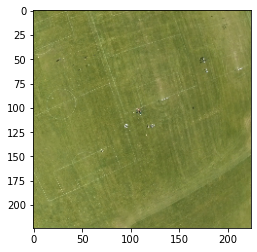

In [52]:
for a,b in tf_data.take(1):
    plt.imshow(a[1,]/255)

In [114]:
a[1,]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[151.74776, 151.53969, 142.94167],
        [155.4001 , 155.20547, 146.675  ],
        [154.83487, 154.63136, 146.05626],
        ...,
        [157.99983, 157.45683, 146.17728],
        [157.28583, 156.85345, 145.46327],
        [165.47008, 165.02719, 153.58427]],

       [[147.02496, 146.8885 , 137.9839 ],
        [155.97594, 155.8644 , 147.0849 ],
        [160.78215, 160.66513, 151.92372],
        ...,
        [159.81685, 159.27385, 147.9943 ],
        [164.96121, 164.51604, 153.06161],
        [165.31212, 164.86694, 153.41252]],

       [[154.94147, 154.95268, 146.13474],
        [164.46567, 164.50146, 155.83168],
        [171.06108, 171.06912, 162.56528],
        ...,
        [159.73563, 159.27568, 147.74715],
        [164.43015, 163.99174, 152.23819],
        [159.21457, 158.77748, 147.08951]],

       ...,

       [[145.9041 , 146.8902 , 135.61574],
        [149.82582, 150.79803, 139.6167 ],
        [152.9535 , 153.966

In [72]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

In [73]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [74]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1000)(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_1 = tf.keras.layers.Dense(1)(x)
output_2 = tf.keras.layers.Dense(8)(x)
output_3 = tf.keras.layers.Dense(36)(x)
model = tf.keras.Model(inputs, [output_1, output_2, output_3])

In [75]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.003),
              loss=[tf.keras.losses.BinaryCrossentropy(from_logits=True), tf.keras.losses.MeanAbsoluteError(), tf.keras.losses.CategoricalCrossentropy(from_logits=True)],
              metrics=['accuracy',"mae", "mse"])

In [78]:
model.fit(tf_data)

      1/Unknown - 11s 11s/step - loss: nan - dense_1_loss: 0.9704 - dense_2_loss: nan - dense_3_loss: nan - dense_1_accuracy: 0.6562 - dense_1_mae: 2.1873 - dense_1_mse: 6.8038 - dense_2_accuracy: 0.1250 - dense_2_mae: nan - dense_2_mse: nan - dense_3_accuracy: 0.0312 - dense_3_mae: nan - dense_3_mse: nan

KeyboardInterrupt: 

In [92]:
DATASET_DIR = "../data/grass_pretrain"
TRUE_NEGATIVES_DIR = "../data/true_negatives_pretrain"


STITCH_PROB = 0.5
TRUE_NEG_PRO = 0.2

alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


list_of_grass_images = glob.glob(DATASET_DIR + "/*jpeg")
list_of_negative_images = glob.glob(TRUE_NEGATIVES_DIR + "/*jpeg")

def align_coords(coords):
    sums = np.array((coords["A_X"] + coords["A_Y"], coords["B_X"] + coords["B_Y"], coords["C_X"] + coords["C_Y"], coords["D_X"] + coords["D_Y"]))
    X = np.array((coords["A_X"], coords["B_X"], coords["C_X"], coords["D_X"]))
    Y = np.array((coords["A_Y"], coords["B_Y"], coords["C_Y"], coords["D_Y"]))
    idx_Y = np.argsort(Y)
    top_left = np.argmin(sums)
    bottom_right = np.argmax(sums)
    a = list(idx_Y)
    a.remove(top_left)
    a.remove(bottom_right)
    top_right = a[0]
    bottom_left = [1]
    return np.array((X[top_left]/1000, Y[top_left]/1000, X[bottom_right]/1000, Y[bottom_right]/1000, X[top_right]/1000, Y[top_right]/1000, X[bottom_left].item()/1000, Y[bottom_left].item()/1000,))

def train_generator(a):
    if random.random() > TRUE_NEG_PRO:
        if random.random() > STITCH_PROB:
            X, coords, letter, color = stitch_random_square(random.choice(list_of_grass_images))
            presence = 1
            position = align_coords(coords)
            enc_letter = np.zeros(36)
            enc_letter[char_to_int[letter]] = 1
        else:
            img_file = random.choice(list_of_grass_images)
            X = np.array(Image.open(img_file))
            presence = 0
            position = np.full(8, np.nan)
            enc_letter = np.full(36, np.nan)
    else:
        img_file = random.choice(list_of_negative_images)
        X = np.array(Image.open(img_file))
        presence = 0
        position = np.full(8, np.nan)
        enc_letter = np.full(36, np.nan)
    # preprocess input for imagenet style
    return X, (presence, position, enc_letter)


def initial_gen():
    for i in range(10000):
        yield i


def retrieve_tf_dataset():

    #actual_gen = tf.py_function(func=train_generator, inp=[tf.int64], Tout=(tf.float32,(tf.int8,tf.float32,tf.float32)))

    tf_data = tf.data.Dataset.from_generator(initial_gen, output_types = tf.int64)
    tf_data = tf_data.map(train_generator, num_parallel_calls=8)
    tf_data = tf_data.prefetch(buffer_size = 200)
    tf_data = tf_data.map((lambda image ,Y: (tf.image.resize(image, (224, 224)), Y)))
    tf_data = tf_data.map((lambda image ,Y: (tf.image.random_contrast(image, 0.8, 1.2), Y)))
    tf_data = tf_data.map((lambda image ,Y: (tf.image.random_brightness(image, 40,), Y)))
    tf_data = tf_data.map((lambda image ,Y: (tf.image.random_saturation(image, 0.8, 1.2), Y)))
    tf_data = tf_data.map((lambda image ,Y: (tf.image.random_hue(image, 0.05), Y)))

    tf_data = tf_data.batch(32)
    return tf_data

In [93]:
a = retrieve_tf_dataset()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


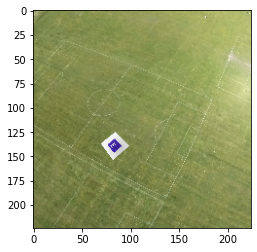

In [96]:
for a,b in tf_data.take(1):
    plt.imshow(a[1,]/255)

In [97]:
b

(<tf.Tensor: shape=(32,), dtype=float32, numpy=
 array([1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
        0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.],
       dtype=float32)>,
 <tf.Tensor: shape=(32, 8), dtype=float32, numpy=
 array([[0.4112162 , 0.3442566 , 0.5519336 , 0.39385116, 0.49890214,
         0.30278158, 0.5519336 , 0.39385116],
        [0.3118374 , 0.6132647 , 0.44213   , 0.62496257, 0.3773689 ,
         0.5591294 , 0.3118374 , 0.6132647 ],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan],
        [0.24777439, 0.6571813 , 0.26366904, 0.7136823 , 0.28365582,
         0.67903364, 0.28365582, 0.67903364],
        [0.24473733, 0.12747061, 0.33516818, 0.19382013, 0.32357544,
         0.12241559, 0.24473733, 0.12747061],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan],
        [0.17444736, 0.2885855 , 0.27903005

In [103]:
import multiprocessing
def train_generator():
    while True:
        if random.random() > TRUE_NEG_PRO:
            if random.random() > STITCH_PROB:
                X, coords, letter, color = stitch_random_square(random.choice(list_of_grass_images))
                presence = 1
                position = align_coords(coords)
                enc_letter = np.zeros(36)
                enc_letter[char_to_int[letter]] = 1
            else:
                img_file = random.choice(list_of_grass_images)
                X = np.array(Image.open(img_file))
                presence = 0
                position = np.full(8, np.nan)
                enc_letter = np.full(36, np.nan)
        else:
            img_file = random.choice(list_of_negative_images)
            X = np.array(Image.open(img_file))
            presence = 0
            position = np.full(8, np.nan)
            enc_letter = np.full(36, np.nan)
        # preprocess input for imagenet style
        yield X, (presence, position, enc_letter)

def bg_parallel():
    def _bg_gen(gen, queue):
        g = gen()
        while True:
            queue.put(next(g))


    pqueue = multiprocessing.Queue()

    p_list = [multiprocessing.Process(target=_bg_gen, args=(train_generator, pqueue)) for x in range(8)]

    [p.start() for p in p_list]
    for i in range(10000):
        yield pqueue.get()

In [104]:
a = bg_parallel()

In [111]:
next(a)

(array([[[121, 141,  78],
         [121, 141,  78],
         [120, 140,  77],
         ...,
         [ 98, 118,  47],
         [ 97, 117,  46],
         [ 97, 117,  46]],
 
        [[119, 139,  76],
         [120, 140,  77],
         [121, 141,  78],
         ...,
         [ 95, 115,  44],
         [ 97, 117,  46],
         [100, 120,  49]],
 
        [[116, 136,  73],
         [119, 139,  76],
         [121, 141,  78],
         ...,
         [ 93, 113,  42],
         [ 95, 115,  44],
         [ 99, 119,  48]],
 
        ...,
 
        [[127, 150,  68],
         [125, 148,  66],
         [127, 150,  68],
         ...,
         [ 80, 111,  33],
         [ 80, 111,  33],
         [ 79, 110,  32]],
 
        [[126, 149,  67],
         [126, 149,  67],
         [129, 152,  70],
         ...,
         [ 80, 111,  33],
         [ 79, 110,  32],
         [ 78, 109,  31]],
 
        [[132, 155,  73],
         [128, 151,  69],
         [128, 151,  69],
         ...,
         [ 81, 112,  34],
  